# Assay validation/final optimization
## background
I've looked at a lot of parameters for this assay and the two most important are volume and enzyme concentration - both of which affect signal strength which is the factor that limits sensitivity of the assay. I also really need to choose some parameters and start screening. This experiment aims to do a final - thesis quality optimization experiment & at the same time make some titration data to validate the assay against.

## aim
- find a combination of volume & enzyme concentration that maximises signal strength, accuracy and sensitivity whilst minimising volume (to save cost)
- compare assay results to titration data for validation & also a baseline to measure accuracy and sensitivity

## fixed parameters
- buffer - 100 mM KPi, pH 7 (no additives)
- %DMSO v/v - 5%
- K - 3

## free parameters
- volume - ```[20, 30, 40]``` - path length affects signal strength, but large volumes require more compound
- [enzyme] - ```[10,15,20]``` - high concentrations give a strong signal, but stochiometry becomes a concern

## targets
- **accuracy vs titrations - kd** - kd varies a lot in literature, I think I'll use pearsons' R for this
- **sensitivity vs titrations** some compounds give a very small spin shift, which may limit detection in my assay. I expect accuracy to decrease with % spin shift and I need a limit of detection so the target will be: ```accuracy / %spin shift```

## compounds
- arachadonic acid
- lauric acid
- palmitic acid
- 4-phenyl imidazole
- sds

## hand-prepped version
- in case I can't access the equipment I need to automate the assay, I'll be testing the assay by hand first. 
### hand-prep protocol
- make protein and buffer stocks in troughs/something suitable for dispensing
- serial dilute compounds in 96 well plates in DMSO 
    - k = 3 
    - max conc
- dispense compounds in columns with a multichanel - 1 column should contain 2 of every conc - 1 for enzyme and 1 for buffer blank, so 
```python
{'A1': 'enzyme + compound 0µM', 
 'B1':'buffer + compound 0 µM',
 'C1': 'enzyme + compound x µM',
 'D1': 'buffer + compound x µM',
 ...
}
```
Below I've designed the experiment by iterating throuh all combinations of the three volumes and concentrations I chose. I've re-named the index of the design dataframe accoring to plate ```1&2``` and the column the experiment is in.

In [1]:
import pandas as pd

concs = [10,15,20]
vols = [20,30,40]
cpds = ['aracadionic acid','lauric','palmitic','4-Ph']


design = pd.DataFrame([{'conc':i,'vol':j, 'cpd':k} for i in concs for j in vols for k in cpds])
print(len(design))
design.index = [i+str(j) for i in ['P1:', 'P2:'] for j in range(1,25)][:len(design)]
design.head()

36


,conc,vol,cpd
P1:1,10,20,aracadionic acid
P1:2,10,20,lauric
P1:3,10,20,palmitic
P1:4,10,20,4-Ph
P1:5,10,30,aracadionic acid


### K values & serial dilution
The K value determines the distribution of compound concentrations: ```k=1``` evenly spaces compound concentrations between a min and a max; ```k=3``` bunches the concentations near zero. I've previously found that a high ```k``` is good for accuracy - especially if the $k_d$ is low. A low $k$ also reduces the ammount of compound needed. ```k=3``` is almost as high as I can go without getting concentrations the echo can't dispense (<2.5 nl in a 20µl well). ```k=3``` is what I've settled on for the automated version of the assay, so I'll use it here.
### how it looks
I've plotted how different ```k``` values look with different $k_d$ and $v_{max}$'s & also how much compund is consumed in that case

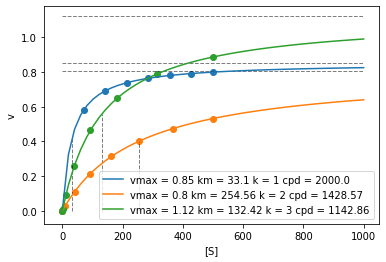

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def make_concs(max_conc, n, k):
    return (np.linspace(0, 1,n ) ** k) * max_conc

def michaelis_menten(vmax, km, s):
    return (vmax * s) / (km + s) # v

x = np.linspace(0,1000,50)
labels = []
for K in [1,2,3]:
    VMAX = np.random.uniform(0.8,1.4)
    KM = np.random.uniform(5,500)
    concs = make_concs(500, 8, K)
    labels.append(f'vmax = {round(VMAX,2)} km = {round(KM,2)} k = {K} cpd = {round(sum(concs),2)}')
    plt.plot(x, [michaelis_menten(VMAX, KM, i) for i in x])
    plt.vlines(x=KM,ymin=0,ymax=michaelis_menten(VMAX,KM,KM),linestyle='--',alpha=0.5,lw=1)
    plt.hlines(y=VMAX,xmin=0,xmax=x.max(),linestyle='--',alpha = 0.5,lw=1)
    plt.scatter(concs,[michaelis_menten(VMAX, KM, i) for i in concs])
plt.xlabel('[S]')
plt.ylabel('v')
plt.legend(labels)
plt.show()

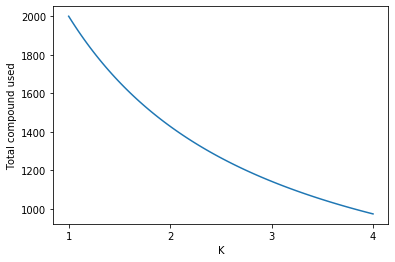

In [3]:
k_range = np.linspace(1,4,100)
plt.plot(k_range,
         [sum(make_concs(500, 8, K)) for K in k_range])
plt.xlabel('K')
plt.ylabel('Total compound used')
plt.xticks([1,2,3,4])
plt.show()

# serial dilution
I'm going to see how closely I can mimic ```k=3``` with serial dilutions. Below I set out a function that makes a list of serial dilution concentrations, and optimize the dilution factor so the Mean squared difference between the target: ```make_concs(max_conc=500,n=8,k=3)``` is minimized.

In [4]:
def frac_dilution(frac, n, max_conc):
    o = [max_conc]
    for i in range(n):
        o.append(o[-1] * frac)
    return o[::-1] # reverse

frac_dilution(0.5, 8, 500)

[1.953125, 3.90625, 7.8125, 15.625, 31.25, 62.5, 125.0, 250.0, 500]

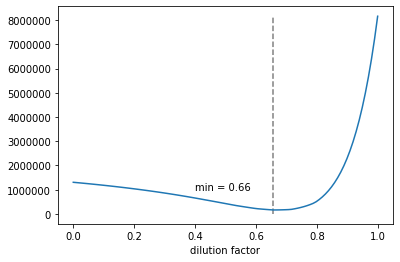

In [5]:
from scipy import optimize # ott 

diff = lambda a,b : sum([abs(a-b) for a,b in zip(a,b)]) ** 2 # mse
target = make_concs(500,8,3)

def objective(frac):
    return diff(frac_dilution(frac,8,500), target)

r = optimize.minimize(objective, x0=0.5)
opt = r.x

xrange = np.linspace(0,1,100)
plt.plot(xrange, [objective(i) for i in xrange])
plt.vlines(x = opt, ymin=0, ymax = objective(1), linestyle='--',alpha=0.5)
plt.text(0.4,1e6,f'min = {round(opt.item(), 2)}')
plt.xlabel('dilution factor')
plt.ylabel('')
plt.show()

## dilution factor =```0.6```
I'll make:
- > 7.2 ml of ```[10, 15, 20]``` µM enzyme
- > 360 µl of each substrate concentration

In [6]:
# vol of each enzyme stock needed
for i in design['conc'].unique():
    print(f"[enzyme]: {i} µM \t total vol: {design.loc[design['conc'] == i, 'vol'].sum()} µl")

[enzyme]: 10 µM 	 total vol: 360 µl
[enzyme]: 15 µM 	 total vol: 360 µl
[enzyme]: 20 µM 	 total vol: 360 µl


In [7]:
# vol of each substrate conc
for i in design['cpd'].unique():
    # 5% v/v dmso * 2 wells (controls)
    print(f"substrate: {i} \t total vol: {design.loc[design['cpd'] == i, 'vol'].sum() * 0.05 * 2} µl")

substrate: aracadionic acid 	 total vol: 27.0 µl
substrate: lauric 	 total vol: 27.0 µl
substrate: palmitic 	 total vol: 27.0 µl
substrate: 4-Ph 	 total vol: 27.0 µl


In [8]:
unique_vols = design['vol'].unique() 
pd.DataFrame(unique_vols * 0.05, 
             index = [f'{i} µl' for i in unique_vols], 
             columns = ['vol cpd'])

,vol cpd
20 µl,1.0
30 µl,1.5
40 µl,2.0


In [9]:
mws = {'aracadionic acid':304.5 , 'lauric':200.32 , 'palmitic':256.42, '4-Ph':176.24}
tgt_vol = 1000 # µl
tgt_wt = lambda mw, tgtVol, tgtConc : mw * (tgtVol / 1e6 ) * (tgtConc / 1e3) # µl & mM

tgt_wts = pd.Series({i:tgt_wt(mws[i], 1000, 100) for i in mws})
tgt_wts

aracadionic acid    0.030450
lauric              0.020032
palmitic            0.025642
4-Ph                0.017624
dtype: float64

In [10]:
actual_wts = pd.Series({'aracadionic acid':0.0351 , 'lauric':0.0196 , 'palmitic':0.0261, '4-Ph':0.0144})

(actual_wts / tgt_wts) * 1000 # vol to add in µl

aracadionic acid    1152.709360
lauric               978.434505
palmitic            1017.861321
4-Ph                 817.067635
dtype: float64

In [11]:
# protein dilution
import sys
sys.path.append('../tools/')
import ProteinConcCheck
bm3_stock = ProteinConcCheck.dataset('20201013-bm3-wt-heme-conc-check.csv')
bm3_stock.calc_conc()

balnk               -0.008700
bm3wt_heme-1in100    3.183812
Name: Concs, dtype: float64

In [12]:
bm3_stock_conc = 3.183812 * 100
bm3_stock_conc

318.38120000000004

In [13]:
def v1(c1,c2,v2):
    return (c2 * v2) / c1

for i in design['conc'].unique():
    total_vol = design.loc[design['conc'] == i,'vol'].sum() * 12 # 1.5 safety
    print(f'conc: {i} µM \t total vol = {total_vol } µl \t \
          of which enzyme: {round(v1(bm3_stock_conc, total_vol, i), 2)} µl')


conc: 10 µM 	 total vol = 4320 µl 	           of which enzyme: 135.69 µl
conc: 15 µM 	 total vol = 4320 µl 	           of which enzyme: 203.53 µl
conc: 20 µM 	 total vol = 4320 µl 	           of which enzyme: 271.37 µl


In [14]:
final_concs = ProteinConcCheck.dataset('20201013-bm3-wt-heme-conc-check-targets.csv')
final_concs.calc_conc()

blank                    0.003500
bm3-wt-heme-tgt-10uM    10.161404
bm3-wt-heme-tgt-15uM    14.284654
bm3-wt-heme-tgt-20uM    19.079105
Name: Concs, dtype: float64

In [15]:
for i in design['cpd'].unique():
    total_vol = design.loc[design['cpd'] == i,'vol'].sum()  * 0.05 # 1.5 safety
    print(f'cpd: {i} \t total vol = {total_vol }')

cpd: aracadionic acid 	 total vol = 13.5
cpd: lauric 	 total vol = 13.5
cpd: palmitic 	 total vol = 13.5
cpd: 4-Ph 	 total vol = 13.5


In [16]:
design['cpd_vol'] = design['vol'] * 0.05
design

,conc,vol,cpd,cpd_vol
P1:1,10,20,aracadionic acid,1.0
P1:2,10,20,lauric,1.0
P1:3,10,20,palmitic,1.0
P1:4,10,20,4-Ph,1.0
P1:5,10,30,aracadionic acid,1.5
P1:6,10,30,lauric,1.5
P1:7,10,30,palmitic,1.5
P1:8,10,30,4-Ph,1.5
P1:9,10,40,aracadionic acid,2.0
P1:10,10,40,lauric,2.0


In [17]:
ls

20201013-bm3-wt-heme-conc-check.csv
20201013-bm3-wt-heme-conc-check-targets.csv
20201013-UV-Vis-Factorial-plate1.CSV
20201013-UV-Vis-Factorial-plate2.CSV
Final-validation-hand.ipynb
